# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Names

- Neve Foresti (data cleaning, analysis & results)
- Emily Chou (data wrangling, data cleaning, analysis & results)
- Sahba Mobini Farahani
- Belen Romero
- Marie Paris

# Group Members IDs

- A########
- A12845123
- A########
- A########

# Research Question

How does the racial demographic data of universities compare with the racial demographic data of the city in which the colleges are located?

## Background and Prior Work

With the continued push for a more educated society, the demand for college degrees in order to obtain a middle-income job has dramatically increased. This need for additional education, after receiving one’s high school diploma, has drastically changed the college enrollment rate by increasing the percentage of enrollment from, “35 percent in 2000 to 41 percent in 2016” (NCES).  Due to this increase, the struggle to attend a top-tier university in the United States has also become more difficult due to the rise in college applications per university. As a result, only students whose resumes depict an exceptional, well-versed student, including a plethora of extra-curriculars in addition to top notch grades, make the cut for these top universities and colleges in the United States. Now with the rise of financial aid, the strive and responsibility for the United States to make all opportunities equal, and the desire for a more diverse college population, our group is curious as to how the racial demographic in both top-tier and bottom colleges compare to the racial demographics of the city in which the university is placed in. 

There has been some data to show that college ready, high-school students are continuously applying to schools that are near metropolitan cities because of the desire of excitement expected in a major city. Thus, top-tier educational institutions are conveniently located close to, or are neighboring, major metropolitan cities, such as New York or Boston. In other cases, top ranked institutions are located in what are now coming to be known as “university cities.” These college towns are a new bread of cities that stand apart from the usual hustle and bustle of city skyscrapers and instead create a unique urban environment which consist of low crime rates, high population education level, and increased participation of the arts. Although these two types of cities contrast each other in which, historically, suburban areas are predominantly caucasion and metropolitan areas are usually more diverse in racial demographic. This leads to the interest in how the racial gap between the university’s racial demographic and the city surrounding the school can play into the change of the city based on the racial make-up of the college in that area.


References (include links):
- 1) https://nces.ed.gov/programs/coe/pdf/coe_cpb.pdf
- 2) https://www.insidehighered.com/news/2017/05/04/author-discusses-new-book-relationships-including-tensions-over-race-and-economics

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

- Dataset Name: U.S. Census Bureau
- Link to the dataset: https://www.census.gov/quickfacts
- Number of observations: all law abiding U.S. citizens over 18 in specified area/63 categories for each city and county/10 cities/10 counties

This dataset provides varying information on specific cities and counties such as racial demographics and population. This data will be used in tandem with the university dataset in order to compare the relationships between colleges and the cities they are located in. 

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [74]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb #to run this you will need to type into your terminal: pip install import-ipynb
import patsy
import statsmodels.api as sm
import os
import re
from collections import OrderedDict

pd.set_option('precision', 2)
pd.set_option('display.max_rows', 10)

# Data Wrangling

All data on cities and counties were sourced from https://www.census.gov/quickfacts.

Because we will be analyzing the impact, if any, of variously ranked colleges on the respective cities and counties they are located in, we want the data to be organized based on ranking, allowing us to easily isolate the analysis.

The U.S. Census Bureau provides us tables with the following data.

In [75]:
cities_dataset_path = './datasets/cities/'
counties_dataset_path = './datasets/counties/'

# create separate dictionaries for each category of colleges that the cities are home to
top_cities = dict()
mid_cities = dict()
bot_cities = dict()
other_cities = dict() # misc areas for further analysis

# populate dicts based on filename indicators
for c in os.listdir(cities_dataset_path):
    # filenames truncated to city-state format for simplicity
    truncated_file_name = '-'.join((c.split('-')[:2]))
    if c.endswith("top-city.csv"):
        top_cities[truncated_file_name] = pd.read_csv(cities_dataset_path + c)
    elif c.endswith("mid-city.csv"):
        mid_cities[truncated_file_name] = pd.read_csv(cities_dataset_path + c)
    elif c.endswith("bot-city.csv"):
        bot_cities[truncated_file_name] = pd.read_csv(cities_dataset_path + c)
    elif '-' in c:
        other_cities[truncated_file_name] = pd.read_csv(cities_dataset_path + c)

# similar process for counties
top_counties = dict()
mid_counties = dict()
bot_counties = dict()
other_counties = dict()

for c in os.listdir(counties_dataset_path):
    # filenames truncated to county-state format for simplicity
    truncated_file_name = '-'.join((c.split('-')[:2]))
    if c.endswith("top-county.csv"):
        top_counties[truncated_file_name] = pd.read_csv(counties_dataset_path + c)
    elif c.endswith("mid-county.csv"):
        mid_counties[truncated_file_name] = pd.read_csv(counties_dataset_path + c)
    elif c.endswith("bot-county.csv"):
        bot_counties[truncated_file_name] = pd.read_csv(counties_dataset_path + c)
    elif '-' in c:
        other_counties[truncated_file_name] = pd.read_csv(counties_dataset_path + c)

# testing
print('============== TOP TEST ===============')
print(top_cities['stanford-ca'])
print('\n============== MID TEST ===============')
print(mid_cities['whitewater-wi'])
print('\n============== BOT TEST ===============')
print(bot_counties['westmoreland-pa'])

============== TOP TEST ===============
                                                 Fact  \
0        Population estimates, July 1, 2018,  (V2018)   
1   Population estimates base, April 1, 2010,  (V2...   
2   Population, percent change - April 1, 2010 (es...   
3                   Population, Census, April 1, 2010   
4                      Persons under 5 years, percent   
..                                                ...   
77                                                 FN   
78                                                NaN   
79                                                  S   
80                                                  X   
81                                                  Z   

                                            Fact Note  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                              

# Data Cleaning

## 1. Preparing County & City Data (Emily)

In [76]:
all_csv = [top_cities, mid_cities, bot_cities, other_cities, top_counties, mid_counties, bot_counties, other_counties]
for d in all_csv:
    for k, v in d.items():
        v.rename(index = str, columns = {v.columns[2] : 'Fact Value'}, inplace = True)

assert top_cities['cambridge-ma'].columns[2] == 'Fact Value'

Currently, the column that should hold the fact value is of type object (str). We want this to be converted to ints so that we do not need to constantly type cast when performing our analysis.

To do this, we need to first delete rows that a fact value that indicates this statistic is not useful such as NA for not available. Further descriptions of the invalid value strings are given in a following section.

In [77]:
assert len(bot_cities['redding-ca'].loc[bot_cities['redding-ca']['Fact Value'] == 'X']) != 0
invalid_values = ['X', 'NA', 'D', '-', 'FN', 'F', 'S', 'Z']
for d in all_csv:
    for k, v in d.items():
        for i, r in v.iterrows():
            if r['Fact Value'] in invalid_values:
                v.drop(i, inplace = True)
                

assert len(bot_cities['redding-ca'].loc[bot_cities['redding-ca']['Fact Value'] == 'X']) == 0

Now, we can iterate through the Fact Value column, strip all non-numeric or . (indicating a decimal number) characters and retype each value from str to float64. We print out the pre and post cleaning types of the Fact Value column to verify our code.

In [78]:
print('Before cleaning:')
print(mid_counties['walworth-wi']['Fact Value'].dtypes)

for d in all_csv:
    for k, v in d.items():
        v.loc[:, 'Fact Value'] = v.loc[:, 'Fact Value'].str.strip('%"$')
        v.loc[:, 'Fact Value'] = v.loc[:, 'Fact Value'].str.replace(',', '')   
        v.loc[:, 'Fact Value'] = v.loc[:, 'Fact Value'].astype('float64')
        
print('\nAfter cleaning:')
print(mid_counties['walworth-wi']['Fact Value'].dtypes)

Before cleaning:
object

After cleaning:
float64


As seen in the initial output of our data wrangling, there are a couple of entirely or largely unneeded *columns* in the data where all the values are either NaN or irrelevant. 

We will be dropping or modifying the following columns to clean the data:

###### Fact Note:

This indicates:

**(a)** Includes persons reporting only one race

**(b)** Hispanics may be of any race, so also are included in applicable race categories

**(c)** Economic Census - Puerto Rico data are not comparable to U.S. Economic Census Data

As none of these factors influence the demographic data of the areas we are analyzing, we can remove this data.

###### Value Note 

This indicates: 

**(-)** Either no or too few sample observations were available to compute an estimate, or a ratio of medians cannot be calculated because one or both of the median estimates falls in the lowest or upper interval of an open ended distribution.	

**(D)**	Suppressed to avoid disclosure of confidential information	

**(F)**	Fewer than 25 firms		

**(FN)** Footnote on this item in place of data	

**(NA)** Not available		

**(S)**	Suppressed; does not meet publication standards

**(X)**	Not applicable

**(Z)**	Value greater than zero but less than half unit of measure shown

Value notes are indicated in the Fact Value column so we do not need the Value Note column at all.

In [79]:
assert top_cities['stanford-ca'].shape == (67, 4)

for d in all_csv:
    for k, v in d.items():
        v.drop([v.columns[1], v.columns[3]], axis = 1, inplace = True)

assert top_cities['stanford-ca'].shape == (67, 2)

We also observe that there are also many *rows* that have a NaN value.

In [80]:
for d in all_csv:
    for k, v in d.items():
        print('NaN values in each column for ' + k + ':\n'+ str(v.isna().sum()))

NaN values in each column for cambridge-ma:
Fact           5
Fact Value    23
dtype: int64
NaN values in each column for newhaven-ct:
Fact           5
Fact Value    23
dtype: int64
NaN values in each column for stanford-ca:
Fact           5
Fact Value    21
dtype: int64
NaN values in each column for jacksonville-il:
Fact           5
Fact Value    23
dtype: int64
NaN values in each column for westerville-oh:
Fact           5
Fact Value    23
dtype: int64
NaN values in each column for whitewater-wi:
Fact           5
Fact Value    23
dtype: int64
NaN values in each column for greensburg-pa:
Fact           5
Fact Value    23
dtype: int64
NaN values in each column for redding-ca:
Fact           5
Fact Value    23
dtype: int64
NaN values in each column for sanbernardino-ca:
Fact           5
Fact Value    23
dtype: int64
NaN values in each column for berkeley-ca:
Fact           5
Fact Value    23
dtype: int64
NaN values in each column for middlesex-ma:
Fact           5
Fact Value    20
dtype:

These NaN rows are not useful, so we will drop these rows entirely.

In [81]:
for d in all_csv:
    for k, v in d.items():
        v.dropna(inplace = True)
        print('NaN values in each column for ' + k + ':\n'+ str(v.isna().sum()))

NaN values in each column for cambridge-ma:
Fact          0
Fact Value    0
dtype: int64
NaN values in each column for newhaven-ct:
Fact          0
Fact Value    0
dtype: int64
NaN values in each column for stanford-ca:
Fact          0
Fact Value    0
dtype: int64
NaN values in each column for jacksonville-il:
Fact          0
Fact Value    0
dtype: int64
NaN values in each column for westerville-oh:
Fact          0
Fact Value    0
dtype: int64
NaN values in each column for whitewater-wi:
Fact          0
Fact Value    0
dtype: int64
NaN values in each column for greensburg-pa:
Fact          0
Fact Value    0
dtype: int64
NaN values in each column for redding-ca:
Fact          0
Fact Value    0
dtype: int64
NaN values in each column for sanbernardino-ca:
Fact          0
Fact Value    0
dtype: int64
NaN values in each column for berkeley-ca:
Fact          0
Fact Value    0
dtype: int64
NaN values in each column for middlesex-ma:
Fact          0
Fact Value    0
dtype: int64
NaN values in e

Because our analysis will only need statistics about demographics, we can drop all rows with irrelevant statistics. We decided to do this last so that, in case we do need to use other statistics, the data for that row will already be cleaned up to this point.

In [82]:
demographic_rows = ['White alone, percent', 'Black or African American alone, percent', 'American Indian and Alaska Native alone, percent', 'Asian alone, percent', 'Native Hawaiian and Other Pacific Islander alone, percent', 'Two or More Races, percent', 'Hispanic or Latino, percent', 'White alone, not Hispanic or Latino, percent']

for d in all_csv:
    for k, v in d.items():
        d[k] = v.loc[(v['Fact'].isin(demographic_rows))]
        # reset index to start from 0 since rows before may have been dropped
        d[k].reset_index(drop = True, inplace = True)

for d in all_csv:
    for k, v in d.items():
        assert d[k].shape == (7, 2) or d[k].shape == (8, 2)

We are now left with dataframes that are of shape either (7, 2) or (8, 2), have no NaN values, have values that are ready to analyze and work with (float type) and only contain relevant demographic statistics.

#### Here is the final cleaned data:

In [83]:
for d in all_csv:
    for k, v in d.items():
        print(k + ' | shape: ' + str(v.shape))
        print(v)
        print('\n')

cambridge-ma | shape: (8, 2)
                                                Fact  Fact Value
0                               White alone, percent        66.9
1           Black or African American alone, percent        10.8
2   American Indian and Alaska Native alone, percent         0.2
3                               Asian alone, percent        15.7
4  Native Hawaiian and Other Pacific Islander alo...         0.1
5                         Two or More Races, percent         4.2
6                        Hispanic or Latino, percent         8.8
7       White alone, not Hispanic or Latino, percent        61.6


newhaven-ct | shape: (8, 2)
                                                Fact  Fact Value
0                               White alone, percent        43.0
1           Black or African American alone, percent        33.0
2   American Indian and Alaska Native alone, percent         0.3
3                               Asian alone, percent         4.7
4  Native Hawaiian and Other Pa

#### Let's convert the data from dictionaries to dataframes. 

In [84]:
#reorder cities dictionaries to correspond with rankings

order_top_cities = OrderedDict()
order_top_cities['cambridge-ma'] = top_cities['cambridge-ma']
order_top_cities['stanford-ca'] = top_cities['stanford-ca']
order_top_cities['newhaven-ct'] = top_cities['newhaven-ct']
top_cities = order_top_cities

order_mid_cities = OrderedDict()
order_mid_cities['westerville-oh'] = mid_cities['westerville-oh']
order_mid_cities['whitewater-wi'] = mid_cities['whitewater-wi']
order_mid_cities['jacksonville-il'] = mid_cities['jacksonville-il']
mid_cities = order_mid_cities

order_bot_cities = OrderedDict()
order_bot_cities['greensburg-pa'] = bot_cities['greensburg-pa']
order_bot_cities['sanbernardino-ca'] = bot_cities['sanbernardino-ca']
order_bot_cities['redding-ca'] = bot_cities['redding-ca']
bot_cities = order_bot_cities

In [85]:
#convert all city csv to dataframe
columns = demographic_rows

df_cities = pd.DataFrame()
i1 = 0
city_csv = [top_cities, mid_cities, bot_cities, other_cities]
for a in city_csv:
    index = 0
    for b in a.keys():
        i2 = 0
        for x in range(0, 8):
            if x < len(city_csv[i1].get(b)["Fact Value"]):
                #if a value is not present (always pacific islander data), we set it equal to zero
                if (len(city_csv[i1].get(b)["Fact Value"]) < 7) and x ==4:
                     df_cities.loc[x,b] = 0
                else:
                    df_cities.loc[x,b] = (city_csv[i1].get(b)["Fact Value"][i2])
            i2 = i2 + 1
    i1 = i1 + 1
    index = index + 1
df_cities = df_cities.transpose()
df_cities

0     1    2     3    4    5     6     7
cambridge-ma      66.9  10.8  0.2  15.7  0.1  4.2   8.8  61.6
stanford-ca       56.6   4.3  0.4  27.0  0.3  9.7  13.6  47.4
newhaven-ct       43.0  33.0  0.3   4.7  0.0  3.9  30.4  30.3
westerville-oh    86.2   8.0  0.0   2.1  0.0  3.2   1.9  84.6
whitewater-wi     87.9   3.8  0.1   2.1  0.6  2.9   9.6  81.8
jacksonville-il   84.9  11.0  0.3   1.0  0.0  2.6   3.9  81.8
greensburg-pa     88.0   6.1  0.0   1.4  0.0  4.4   2.1  86.3
sanbernardino-ca  57.4  14.1  0.7   4.5  0.2  4.6  64.3  15.3
redding-ca        84.3   1.4  2.2   4.8  0.0  4.7  10.1  77.9
berkeley-ca       60.2   8.6  0.5  19.7  0.5  7.1  11.0  54.6

In [86]:
#reorder county dictionaries to correspond with rankings

order_top_counties = OrderedDict()
order_top_counties['middlesex-ma'] = top_counties['middlesex-ma']
order_top_counties['santaclara-ca'] = top_counties['santaclara-ca']
order_top_counties['newhaven-ct'] = top_counties['newhaven-ct']
top_counties = order_top_counties

order_mid_counties = OrderedDict()
order_mid_counties['delaware-oh'] = mid_counties['delaware-oh']
order_mid_counties['walworth-wi'] = mid_counties['walworth-wi']
order_mid_counties['morgan-il'] = mid_counties['morgan-il']
mid_counties = order_mid_counties

order_bot_counties = OrderedDict()
order_bot_counties['westmoreland-pa'] = bot_counties['westmoreland-pa']
order_bot_counties['sanbernardino-ca'] = bot_counties['sanbernardino-ca']
order_bot_counties['shasta-ca'] = bot_counties['shasta-ca']
bot_counties = order_bot_counties

In [87]:
#convert all county csv to dataframe
df_counties = pd.DataFrame()
i1 = 0
county_csv = [top_counties, mid_counties, bot_counties, other_counties]
for a in county_csv:
    index = 0
    for b in a.keys():
        bool = False
        i2 = 0
        for x in range(0, 8):
            if len(county_csv[i1].get(b)["Fact Value"]) < 8 and x==4:
                bool = True
                df_counties.loc[x,b] = 0
            elif bool == True:
                df_counties.loc[x,b] = (county_csv[i1].get(b)["Fact Value"][i2-1])
            else:
                df_counties.loc[x,b] = (county_csv[i1].get(b)["Fact Value"][i2])
            i2 = i2 + 1
    i1 = i1 + 1
    index = index + 1
df_counties = df_counties.transpose()
df_counties

0     1    2     3    4    5     6     7
middlesex-ma      79.2   5.8  0.3  12.3  0.1  2.4   8.0  72.5
santaclara-ca     53.8   2.8  1.2  37.5  0.5  4.1  25.6  31.6
newhaven-ct       77.9  14.7  0.5   4.3  0.1  2.4  18.1  63.0
delaware-oh       87.5   3.6  0.2   6.6  0.0  2.0   2.6  85.3
walworth-wi       95.8   1.3  0.5   1.1  0.1  1.3  11.4  85.2
morgan-il         90.7   6.3  0.4   0.7  0.1  1.8   2.4  88.8
westmoreland-pa   94.9   2.5  0.1   1.0  0.0  1.5   1.2  93.9
sanbernardino-ca  76.9   9.4  2.1   7.6  0.5  3.5  53.4  28.6
shasta-ca         88.0   1.1  3.1   3.1  0.2  4.4  10.1  79.8
alameda-ca        50.2  11.3  1.1  31.1  1.0  5.3  22.5  31.5

In [88]:
for indexr, city in df_cities.iterrows():
    for indexc, newvalue in city.iteritems():
        if "." in str(newvalue):
            oldvalue = (newvalue)
            newvalue = (float(newvalue)) / 100
            df_cities.loc[indexr,indexc] = round(newvalue, 2)

df_cities.columns = ["White all", "African American", "Native American", "Asian", "Pacific Islander", "Multiracial", "Hispanic", "White"]
df_cities['Unknown'] = 1 - df_cities["White"] - df_cities["African American"]-df_cities["Native American"] -df_cities["Asian"]-df_cities["Pacific Islander"] -df_cities["Multiracial"]
df_cities = df_cities.drop("White all", axis=1)

cols = ['African American', 'Asian', 'Hispanic', 'Multiracial',
       'Native American', 'Pacific Islander', 'Unknown', 'White']
df_cities = df_cities[cols]
df_cities

African American  Asian  Hispanic  Multiracial  \
cambridge-ma                  0.11   0.16      0.09         0.04   
stanford-ca                   0.04   0.27      0.14         0.10   
newhaven-ct                   0.33   0.05      0.30         0.04   
westerville-oh                0.08   0.02      0.02         0.03   
whitewater-wi                 0.04   0.02      0.10         0.03   
jacksonville-il               0.11   0.01      0.04         0.03   
greensburg-pa                 0.06   0.01      0.02         0.04   
sanbernardino-ca              0.14   0.04      0.64         0.05   
redding-ca                    0.01   0.05      0.10         0.05   
berkeley-ca                   0.09   0.20      0.11         0.07   

                  Native American  Pacific Islander  Unknown  White  
cambridge-ma                 0.00              0.00     0.07   0.62  
stanford-ca                  0.00              0.00     0.12   0.47  
newhaven-ct                  0.00              0.00     0.28   0.30  
westerville-oh               0.00              0.00     0.02   0.85  
whitewater-wi                0.00              0.01     0.08   0.82  
jacksonville-il              0.00              0.00     0.03   0.82  
greensburg-pa                0.00              0.00     0.03   0.86  
sanbernardino-ca             0.01              0.00     0.61   0.15  
redding-ca                   0.02              0.00     0.09   0.78  
berkeley-ca                  0.01              0.01     0.07   0.55

In [89]:
for indexr, county in df_counties.iterrows():
    for indexc, newvalue in county.iteritems():
        if "." in str(newvalue):
            oldvalue = (newvalue)
            newvalue = (float(newvalue)) / 100
            df_counties.loc[indexr,indexc] = round(newvalue, 2)

df_counties.columns = ["White all", "African American", "Native American", "Asian", "Pacific Islander", "Multiracial", "Hispanic", "White"]
df_counties['Unknown'] = 1 - df_counties["White"] - df_counties["African American"]-df_counties["Native American"] -df_counties["Asian"]-df_counties["Pacific Islander"] -df_counties["Multiracial"]
df_counties = df_counties.drop("White all", axis=1)
cols = ['African American', 'Asian', 'Hispanic', 'Multiracial',
       'Native American', 'Pacific Islander', 'Unknown', 'White']
df_counties = df_counties[cols]
df_counties

African American  Asian  Hispanic  Multiracial  \
middlesex-ma                  0.06   0.12      0.08         0.02   
santaclara-ca                 0.03   0.38      0.26         0.04   
newhaven-ct                   0.15   0.04      0.18         0.02   
delaware-oh                   0.04   0.07      0.03         0.02   
walworth-wi                   0.01   0.01      0.11         0.01   
morgan-il                     0.06   0.01      0.02         0.02   
westmoreland-pa               0.03   0.01      0.01         0.01   
sanbernardino-ca              0.09   0.08      0.53         0.04   
shasta-ca                     0.01   0.03      0.10         0.04   
alameda-ca                    0.11   0.31      0.23         0.05   

                  Native American  Pacific Islander  Unknown  White  
middlesex-ma                 0.00              0.00     0.08   0.72  
santaclara-ca                0.01              0.01     0.21   0.32  
newhaven-ct                  0.01              0.00     0.15   0.63  
delaware-oh                  0.00              0.00     0.02   0.85  
walworth-wi                  0.01              0.00     0.11   0.85  
morgan-il                    0.00              0.00     0.02   0.89  
westmoreland-pa              0.00              0.00     0.01   0.94  
sanbernardino-ca             0.02              0.01     0.47   0.29  
shasta-ca                    0.03              0.00     0.09   0.80  
alameda-ca                   0.01              0.01     0.19   0.32

## 2. Preparing University Data (Neve)

First, using the Beautiful Soup package, we created a script to web scrape the 37 pages of ranked public and private [Best Colleges of Niche.com](https://www.niche.com/colleges/search/best-colleges/). 
For pages 1-37, we sent requests to https://www.niche.com/api/renaissance/results/?type=private&type=public&listURL=best-colleges&page=, which contained information about rankings, names, and links to more information about each of the colleges. For each of these colleges, we then added the unique college link to https://www.niche.com/colleges/. For example, https://www.niche.com/colleges/massachusetts-institute-of-technology/. Lastly, we used Beautiful Soup to extract and print all of the undergraduate population and student racial demographic data to a csv. For the few universities that had missing data, we manually searched the university in Niche.com and entered the demographic data.


In [90]:
#get racial demographic data
df_niche = pd.read_csv("datasets/niche4yearpublicprivate.csv")
df_niche.head(5)

ranking                                   name African American Asian  \
0        1  massachusetts-institute-of-technology               6%   25%   
1        2                    stanford-university               6%   20%   
2        3                     harvard-university               6%   20%   
3        4                        yale-university               6%   15%   
4        5                   princeton-university               7%   20%   

  Hispanic International Multiracial Native American Pacific Islander Unknown  \
0      15%           12%          6%              0%               0%      2%   
1      14%           14%         10%              1%               0%      1%   
2      11%            8%          5%              0%               0%      4%   
3      11%           19%          5%              1%               0%      3%   
4       9%           12%          4%              0%               0%      6%   

  White  
0   34%  
1   34%  
2   44%  
3   40%  
4   41%

#### As you can see, there are quite a few things that need to be done. 
1. All of the values in this dataframe are strings. Hence, we need to convert the demographic data to numeric values. 
2. The demographic measurements do not match up with the measurements for the city/county census data. Census data does not have an "international" category, so in order to compare college with county data, we dropped the International category. We recognize that many of the international students may actually fall into the other categories (and hence result in underrepresenting numbers for some races), but there is no way to know. This is a limitation of how demographic data is collected for colleges, so we will be cautious.

In [91]:
#check if any null values. If null,manually enter data from niche.com
df_niche[df_niche.isnull().any(axis=1)]

df_niche = df_niche.drop("International", axis=1)


for indexr, university in df_niche.iterrows():
    sum = 0
    for indexc, newvalue in university.iteritems():
        if "%" in str(newvalue):
            oldvalue = (newvalue)
            newvalue = (float(newvalue.rstrip("%"))) / 100
            df_niche.loc[indexr,indexc] = newvalue
            sum = sum + newvalue #get the sum of all percentages in a row (will not add up to 1.0)
    # Here we want to get the proportion of the demographics to each other (after having removed International)
    for indexc, newvalue in university.iteritems():
        if isinstance(df_niche.loc[indexr,indexc], float):
            #find relative proportion of demographics by diving with row total
            df_niche.loc[indexr,indexc] = round((float(df_niche.loc[indexr,indexc]) / sum),2)

df_800 = df_niche #top 800 #top 800 colleges will be used for analysis 1
df_500 = df_niche.head(500) #top 500 colleges will be used for analysis 2
df_800

ranking                                          name African American  \
0          1         massachusetts-institute-of-technology             0.07   
1          2                           stanford-university             0.07   
2          3                            harvard-university             0.07   
3          4                               yale-university             0.07   
4          5                          princeton-university             0.08   
..       ...                                           ...              ...   
875      876                    houston-baptist-university             0.19   
876      877        school-of-the-art-institute-of-chicago             0.04   
877      878                         seton-hill-university             0.05   
878      879  california-state-university---san-bernardino             0.06   
879      880                            simpson-university             0.04   

    Asian Hispanic Multiracial Native American Pacific Islander Unknown White  
0    0.28     0.17        0.07               0                0    0.02  0.39  
1    0.23     0.16        0.12            0.01                0    0.01   0.4  
2    0.22     0.12        0.06               0                0    0.04  0.49  
3    0.19     0.14        0.06            0.01                0    0.04  0.49  
4    0.23      0.1        0.05               0                0    0.07  0.47  
..    ...      ...         ...             ...              ...     ...   ...  
875   0.1     0.32        0.04               0                0    0.08  0.27  
876  0.16     0.16        0.04               0                0    0.07  0.51  
877  0.01     0.03        0.02               0                0    0.06  0.83  
878  0.06     0.66        0.03               0                0    0.04  0.14  
879  0.04     0.14        0.03            0.03                0    0.11  0.61  

[880 rows x 10 columns]

# Data Analysis & Results

## Analysis 1 (Neve and Emily)
### For the first part of the analysis, we are interested in looking at how racial demographic data of colleges compares with their surrounding county. 

In [92]:
def bar_plot_county_city(county_name, college_name, top_mid_bot, county_color, college_color):
    ind = np.arange(8) 
    width = 0.42

    plt.bar(ind, df_counties.loc[county_name].values, width, label = ""+county_name+" (county)", color = county_color)
    df_temp = (df_800.loc[df_800['name'] == college_name]).drop(columns = ['ranking', 'name'])
    plt.bar(ind + width, df_temp.values[0], width, label = ""+college_name+" (college)", color = college_color)

    plt.xticks(ind + width / 2, df_counties.columns)
    plt.ylabel('Percentage of Total Population')
    plt.title('Ethnicity Percentages for ' + top_mid_bot + ' 3 Ranked County & University')
    plt.legend(loc='best')
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')


In the following bar graphs, the absence of a bar denotes less than 0 percent of the population.

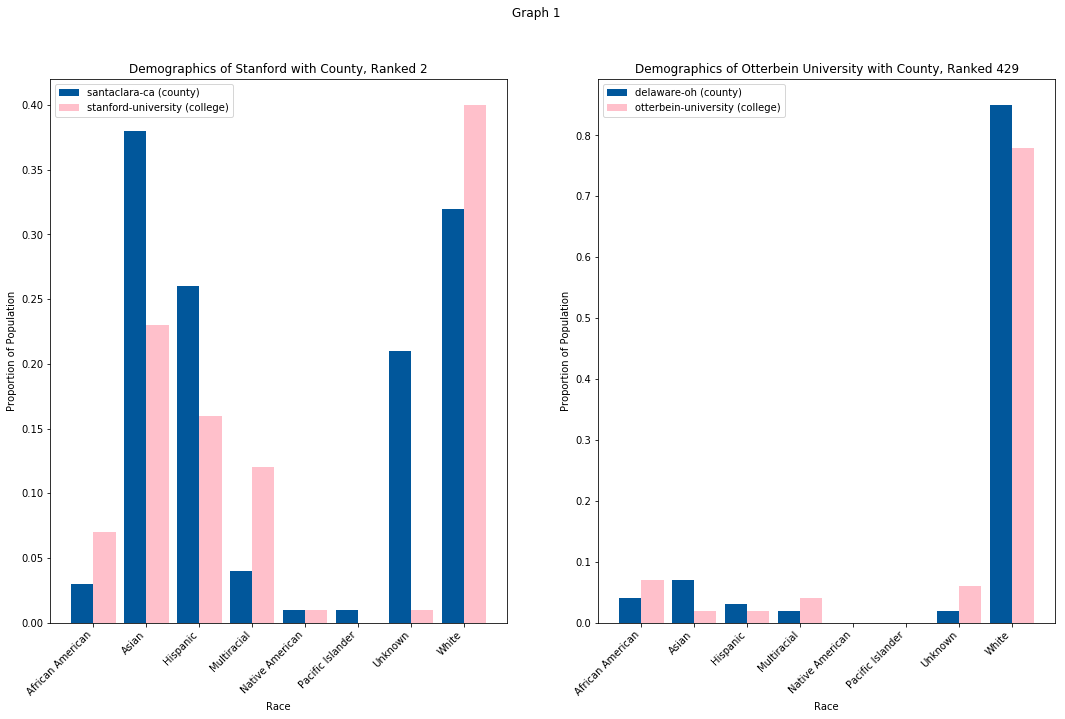

In [93]:
f = plt.figure(figsize=(18,10))
f.suptitle('Graph 1')

plt.subplot(1,2,1)
bar_plot_county_city('santaclara-ca', 'stanford-university', 'Top', '#01579b', "pink")
plt.title("Demographics of Stanford with County, Ranked 2")
plt.xlabel('Race')
plt.ylabel('Proportion of Population')

plt.subplot(1,2,2)
bar_plot_county_city('delaware-oh', 'otterbein-university', 'Middle', '#01579b', 'pink')
plt.title("Demographics of Otterbein University with County, Ranked 429")
plt.xlabel('Race')
plt.ylabel('Proportion of Population')

plt.show()

The graphs above show the possible variation. Stanford, with a high "Best Colleges" ranking of 2 clearly has racial demographic data very different from the surrounding county. On the other hand, Otterbein University, a college ranked at 429 has less diversity, but has demographics very similar to the surrounding county of Delaware, Ohio.

We are therefore interested in looking at whether ranking is correlated with not only how diverse racial demographics of a campus are, but also how that spread compares with the surrounding city.

## Question: Is there a relationship between the ranking tier (top, middle, bottom) and the similarity between the college and surrounding county demographics?

#### Hypothesis: Top-ranked universities tend to be magnet schools and pull students from all over the nation. Also, in our experience, there is more pressure for top-ranked schools to be racially diverse, whereas counties don't often have racial demographics split equally. Hence, our intuition is that their demographics will not match the counties. Lower-ranked universities often have local students. We hypothesize that lower ranked schools will have higher racial demographic similarity with the surrounding county. 

#### Summary: To answer this question, we create a "diversity metric", a single value for each college or county, to compare. We do this for the top 3 (1-3), middle 3 (429-431), and bottom 3 (878-880) ranked colleges. 

#### Limitations: We recognize that 9 datapoints in 3 different categories ("top", "middle", and "bottom") is not enough to create accurate inferences. However, for each county, we need to manually download data. Hence, due to time constraints, we cannot do this analysis with as much data as we would like. We will be cautious of this while making inferences. 

### Step 1: Before we compare each of the colleges with their counties, we do the analysis for colleges and counties separately.

First, we create the dataframe just including the college data for the top 3, middle 3, and bottom 3 colleges.

In [94]:
df_topmidbot = df_800[:3]
df_topmidbot = df_topmidbot.append([df_800[428:431], df_800[877:881]])
df_topmidbot = df_topmidbot.drop(columns=["name"]) # name is unnecessary information for this analysis
df_topmidbot.index = df_topmidbot["ranking"]
df_topmidbot.index.names = ['orig_rank']
df_topmidbot.ranking = pd.to_numeric(df_topmidbot["ranking"]) #ranking was previously a string value
df_topmidbot

ranking African American Asian Hispanic Multiracial  \
orig_rank                                                        
1                1             0.07  0.28     0.17        0.07   
2                2             0.07  0.23     0.16        0.12   
3                3             0.07  0.22     0.12        0.06   
429            429             0.07  0.02     0.02        0.04   
430            430             0.04  0.02     0.06        0.04   
431            431             0.13  0.01     0.09        0.04   
878            878             0.05  0.01     0.03        0.02   
879            879             0.06  0.06     0.66        0.03   
880            880             0.04  0.04     0.14        0.03   

          Native American Pacific Islander Unknown White  
orig_rank                                                 
1                       0                0    0.02  0.39  
2                    0.01                0    0.01   0.4  
3                       0                0    0.04  0.49  
429                     0                0    0.06  0.78  
430                     0                0       0  0.84  
431                     0                0       0  0.73  
878                     0                0    0.06  0.83  
879                     0                0    0.04  0.14  
880                  0.03                0    0.11  0.61

Then, we must create the "diversity metric". We initially tested using the mean as the metric, but for most colleges the metric was .19 or .20. This meant that all of the colleges and counties had the same diversity value, which is clearly not the case, as seen in Graph 1. Hence, we decided to use the variance for each college row as the metric because the value gives more information about dispersion of the racial demographics.

In [95]:
df_topmidbot["var"] =  df_topmidbot.loc[:, ["African American", "Asian", "Hispanic","Multiracial","White"]].var(axis=1)
df_topmidbot

ranking African American Asian Hispanic Multiracial  \
orig_rank                                                        
1                1             0.07  0.28     0.17        0.07   
2                2             0.07  0.23     0.16        0.12   
3                3             0.07  0.22     0.12        0.06   
429            429             0.07  0.02     0.02        0.04   
430            430             0.04  0.02     0.06        0.04   
431            431             0.13  0.01     0.09        0.04   
878            878             0.05  0.01     0.03        0.02   
879            879             0.06  0.06     0.66        0.03   
880            880             0.04  0.04     0.14        0.03   

          Native American Pacific Islander Unknown White   var  
orig_rank                                                       
1                       0                0    0.02  0.39  0.02  
2                    0.01                0    0.01   0.4  0.02  
3                       0                0    0.04  0.49  0.03  
429                     0                0    0.06  0.78  0.11  
430                     0                0       0  0.84  0.13  
431                     0                0       0  0.73  0.09  
878                     0                0    0.06  0.83  0.13  
879                     0                0    0.04  0.14  0.07  
880                  0.03                0    0.11  0.61  0.06

In [96]:
# College Data
# To get "top", "middle", "bottom" categories, change ranking to values of 0-2.
df_topmidbot.ranking.loc[(df_topmidbot['ranking'] < 4)] = 0
df_topmidbot.ranking.loc[(df_topmidbot['ranking'] >= 4) & (df_topmidbot['ranking'] < 432)] = 1
df_topmidbot.ranking.loc[(df_topmidbot['ranking'] > 877)] = 2
# County data
#remove Alameda, which is used for exploratory phase, and is not needed for Analysis 1
df_topmidbot_county = df_counties.drop("alameda-ca")
df_topmidbot_county["ranking"] = [0,0,0,1,1,1,2,2,2]
df_topmidbot_county = df_topmidbot_county.copy(deep=True)
df_topmidbot_county["var"] =  df_topmidbot_county.loc[:, ["African American", "Asian", "Hispanic","Multiracial","White"]].var(axis=1)

Text(0, 0.5, 'Diversity Metric')

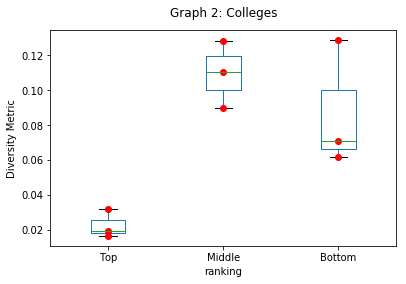

In [97]:
graph2 = df_topmidbot.boxplot(by ='ranking',column =['var'], grid = False) 
plt.plot(df_topmidbot["ranking"]+1, df_topmidbot["var"],'r.',alpha=1,marker='o')
plt.suptitle("Graph 2: Colleges")
plt.title("")
plt.xticks([1, 2, 3], ['Top', 'Middle', 'Bottom'])
graph2.set_ylabel('Diversity Metric')

This graph suggests 3 things:
1. top colleges have low dispersion, and hence have more equal proportions for various races. 
2. as ranking increases, there is more variability in diversity between colleges of similar rankings.
3. While there is an overall increase in the diversity metric, there does not seem to be a linear relationship.

Text(0, 0.5, 'Diversity Metric')

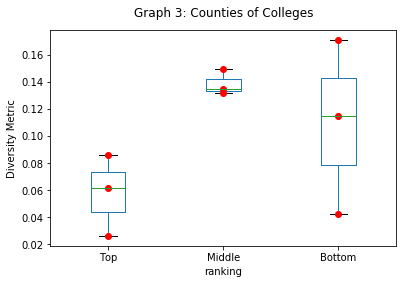

In [98]:
graph3 = df_topmidbot_county.boxplot(by ='ranking', column =['var'], grid = False) 
plt.plot(df_topmidbot_county["ranking"]+1, df_topmidbot_county["var"],'r.',alpha=1,marker='o')
plt.xticks([1, 2, 3], ['Top', 'Middle', 'Bottom'])
plt.suptitle("Graph 3: Counties of Colleges")
plt.title("")
graph3.set_ylabel('Diversity Metric')

This graph suggests 3 things:
1. There is a similar trend in the diversity metric means as in graph 2. The trend of variability is not consistent; however, the counties of the bottom ranked category also have the highest variability.

### Step 2: Compare each of the colleges with their counties

In [99]:
df_topmidbot_county = df_topmidbot_county.set_index("ranking") # set index so same as df_topmidbot_county index
df_summary = df_topmidbot_county["var"].sub(df_topmidbot["var"], axis = 0).to_frame() 
df_summary

var
ranking          
0        6.65e-02
0        9.75e-03
0        2.97e-02
1        2.09e-02
1        6.52e-03
1        5.92e-02
2        4.22e-02
2       -2.85e-02
2        5.32e-02

Text(0, 0.5, 'Difference between College and County Diversity Metric')

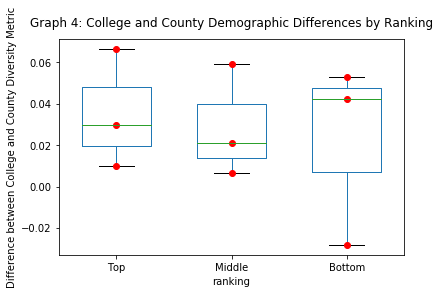

In [100]:
graph4 = df_summary.boxplot(by ='ranking', column =['var'], widths = 0.6,grid = False)
plt.suptitle("Graph 4: College and County Demographic Differences by Ranking")
plt.title("")
plt.plot(df_summary.index+1, df_summary["var"],'r.',alpha=1,marker='o')
plt.xticks([1, 2, 3], ['Top', 'Middle', 'Bottom'])
graph4.set_ylabel('Difference between College and County Diversity Metric')

The graph suggests that there is in fact a slight correlation. As the ranking decreases, the diversity metric of colleges and their surrounding county also decreases somewhat. The correlation seems weak, but we will do a linear regression analysis to determine the extent of this correlation.

In [101]:
df_var_summary = pd.DataFrame(columns = ['county', 'college']) 
df_var_summary['college'] = df_topmidbot.loc[df_topmidbot["ranking"] == 0]['var'].values
df_var_summary['county'] = df_topmidbot_county['var'].values[:3]

outcome, predictors = patsy.dmatrices('college ~ county', df_var_summary)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                college   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.847
Method:                 Least Squares   F-statistic:                   0.08301
Date:                Sun, 26 May 2019   Prob (F-statistic):              0.821
Time:                        12:33:28   Log-Likelihood:                 10.897
No. Observations:                   3   AIC:                            -17.79
Df Residuals:                       1   BIC:                            -19.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0181      0.016      1.105      0.4

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


In [102]:
df_var_summary['college'] = df_topmidbot.loc[df_topmidbot["ranking"] == 1]['var'].values
df_var_summary['county'] = df_topmidbot_county['var'].values[3:6]

outcome, predictors = patsy.dmatrices('college ~ county', df_var_summary)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                college   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     1.779
Date:                Sun, 26 May 2019   Prob (F-statistic):              0.410
Time:                        12:33:28   Log-Likelihood:                 9.7473
No. Observations:                   3   AIC:                            -15.49
Df Residuals:                       1   BIC:                            -17.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3362      0.170      1.976      0.2

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


In [103]:
df_var_summary['college'] = df_topmidbot.loc[df_topmidbot["ranking"] == 2]['var'].values
df_var_summary['county'] = df_topmidbot_county['var'].values[6:9]

outcome, predictors = patsy.dmatrices('college ~ county', df_var_summary)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                college   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     1.306
Date:                Sun, 26 May 2019   Prob (F-statistic):              0.458
Time:                        12:33:28   Log-Likelihood:                 7.5399
No. Observations:                   3   AIC:                            -11.08
Df Residuals:                       1   BIC:                            -12.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0408      0.045      0.903      0.5

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


As seen from the OLS regression results above, the p values of the parameter, county, is always greater than our alpha significance level (0.01), meaning that there no significant difference. Thus, we will not reject the null hypothesis. However, the p value does decrease from top level colleges/cities to mid and bottom level colleges/cities indicating that there is more correlation between mid and bottom level colleges/cities than between top level colleges/cities.

# Ethics & Privacy

The data involving higher education-specific demographics was posted on Niche for anyone to view. We were required to contact Niche for specific permission to use/analyze their data for academic purposes. Niche found its statistics from various official public sources including the FBI, the U.S. Census, and the Department of Education. The data from Niche provides us the racial demographics of the student bodies of 810 4-year colleges and universities in the United States. Categories include: African American, Asian, Hispanic, International, Multiracial, Native American, Pacific Islander, Unknown, White. Our analysis might not prefer the categories of ‘Multiracial’ and ‘Unknown’ since these categories can add noise to our final result and do not give us insight into any specific race. There is also a concern for the category ‘White’, because this can represent both Europeans and Middle Easterns, which racially are equivalent but are societally seen as separate. Niche’s data does not include the number of students enrolled nor any information about any one student.

We also utilize city data from the 2010 U.S. Census, looking at city specific racial demographics for cities with populations over 5,000 people: White, Black/African American, American Indian/Alaska Native, Asian, Native Hawaiian/Other Pacific Islander, Two or More Races, Hispanic/Latino. The discrepancy between our data sources’ categories are ‘International’ and ‘Unknown’, which are specific to Niche’s data. Since we do not look into anything more specific than percentages within colleges and cities, we do not invade the personal privacy of our subjects. Aside from what has already been mentioned, we do not anticipate any other issues related to privacy and equitable impact due to the public nature of this dataset (people are aware that their demographics are recorded in college admissions as well as on the U.S. Census).

# Conclusion & Discussion

*Fill in your discussion information here*